# Frontal Detection Analysis (Jet shifts)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cf_xarray
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

## Bring in dask resources for plotting
NOTE: monthly time index preprocessing function will not work with dask so need to load dask resources after reading in monthly data, or do monthly time correction after reading in data

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 nodes (10 dask workers)
cluster.scale(10)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37391 instead
  warnings.warn(


In [3]:
client

<Client: 'tcp://10.12.206.51:40760' processes=0 threads=0, memory=0 B>

## Filepaths

In [4]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output
cesm_rcp26_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP26C5CN/" # RCP2.6 output
cesm_rcp85_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP85C5CN/" #RCP8.5 output

## Zonal wind field files

In [7]:
# h0.U300 is monthly mean 300mb zonal wind
# remapped from unstructured grid to FV

U300_B20TRC5CN_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h0.U300.200001-200512.regrid_0.23x0.31.nc"
U300_BRCP26C5CN_files = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h0.U300.200601-201512.regrid_0.23x0.31.nc"
U300_BRCP85C5CN_files = "*h0.U300*regrid*.nc"

In [8]:
U300_hist_files = [cesm_hist_filepath+U300_B20TRC5CN_files, cesm_rcp26_filepath+U300_BRCP26C5CN_files] # combined hist/rcp26; need explicit filenames (not glob strings) if using a list
U300_rcp_files = cesm_rcp85_filepath+U300_BRCP85C5CN_files

In [9]:
U300_hist_files

['/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/b.e13.B20TRC5CN.ne120_g16.003.cam.h0.U300.200001-200512.regrid_0.23x0.31.nc',
 '/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP26C5CN/b.e13.BRCP26C5CN.ne120_g16.003.cam.h0.U300.200601-201512.regrid_0.23x0.31.nc']

### Preprocessing function for zonal wind

In [6]:
def preprocess_U300(ds):
    # fix CESM time bounds for monthly output
    attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
    time_bounds = ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
    time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
    ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
    ds.time.attrs, ds.time.encoding = attrs, encoding
    # return regional domain
    return ds['U300'].sel(lat=slice(10,77),lon=slice(189,329))

### Read in U300 files with or without preprocessing function

In [10]:
%%time
#U300_hist = xr.open_mfdataset(U300_hist_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess_U300) # unclear if chunking is needed for these monthly (smaller) files
U300_hist_ds = xr.open_mfdataset(U300_hist_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True)

CPU times: user 314 ms, sys: 36.1 ms, total: 350 ms
Wall time: 5.45 s


In [11]:
#U300_hist
U300_hist_ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 768, lon: 1152, nbnd: 2, slat: 767, slon: 1152, time: 192)
Coordinates:
  * lat        (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon        (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * slat       (slat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
  * slon       (slon) float64 0.0 0.1562 0.4688 0.7812 ... 358.9 359.2 359.5
  * time       (time) object 2000-02-01 00:00:00 ... 2016-01-01 00:00:00
Dimensions without coordinates: bnds, nbnd
Data variables:
    w_stag     (time, slat) float64 dask.array<chunksize=(72, 767), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(72, 768, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(72, 1152, 2), meta=np.ndarray>
    gw         (time, lat) float64 dask.array<chunksize=(72, 768), meta=np.ndarray>
    area       (time, lat, lon) float64 dask.array<chunksize=(72, 768, 1152), meta=np.ndarray>
    U300       (time, lat, lon) float32 dask.array<chunksize=(72, 768, 1152), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(72, 2), meta=np.ndarray>
Attributes: (12/30)
    creation_date:              Mon Mar 21 20:03:59 MDT 2022
    Conventions:                CF-1.0
    source_file:                /glade/scratch/kdagon/FrontDetector/B20TRC5CN...
    data_script:                ncl script using vinth2p_nodes
    cesm_contact:               John Truesdale, jet@ucar.edu
    data_creator:               Katie Dagon, kdagon@ucar.edu
    ...                         ...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc38
    remap_version:              4.7.9
    map_file:                   /glade/work/nanr/mapfiles/map_ne120_to_0.23x0...
    input_file:                 /glade/scratch/kdagon/FrontDetector/B20TRC5CN...

### Monthly time index correction

In [12]:
attrs, encoding = U300_hist_ds.time.attrs.copy(), U300_hist_ds.time.encoding.copy()
time_bounds = U300_hist_ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
time_bounds_dim_name = U300_hist_ds.cf.get_bounds_dim_name('time')
U300_hist_ds = U300_hist_ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
U300_hist_ds.time.attrs, U300_hist_ds.time.encoding = attrs, encoding
U300_hist = U300_hist_ds['U300'].sel(lat=slice(10,77),lon=slice(189,329))
U300_hist

<xarray.DataArray 'U300' (time: 192, lat: 285, lon: 448)>
dask.array<getitem, shape=(192, 285, 448), dtype=float32, chunksize=(120, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-16 12:00:00 ... 2015-12-16 12:00:00
Attributes:
    long_name:      Zonal wind at 300 mbar pressure surface
    units:          m/s
    plevo:          300.0
    cell_measures:  area: area

### Subset historical to match number of RCP8.5 years (14)

In [13]:
#U300_hist.sel(time="2000-01") # this works
#U300_hist.sel(time="2014-12") # this works
#U300_hist.sel(time=slice("2000-01", "2014-12")) # this breaks??
U300_hist = U300_hist[:180] 
U300_hist

<xarray.DataArray 'U300' (time: 180, lat: 285, lon: 448)>
dask.array<getitem, shape=(180, 285, 448), dtype=float32, chunksize=(108, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      Zonal wind at 300 mbar pressure surface
    units:          m/s
    plevo:          300.0
    cell_measures:  area: area

In [14]:
U300_rcp_files

'/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP85C5CN/*h0.U300*regrid*.nc'

In [15]:
#U300_rcp = xr.open_mfdataset(U300_rcp_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess_U300)
#U300_rcp
U300_rcp_ds = xr.open_mfdataset(U300_rcp_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True)
U300_rcp_ds

<xarray.Dataset>
Dimensions:    (lat: 768, lon: 1152, nbnd: 2, slat: 767, slon: 1152, time: 180)
Coordinates:
  * lat        (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon        (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * slat       (slat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
  * slon       (slon) float64 0.0 0.1562 0.4688 0.7812 ... 358.9 359.2 359.5
  * time       (time) object 2086-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    w_stag     (time, slat) float64 dask.array<chunksize=(12, 767), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(12, 768, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(12, 1152, 2), meta=np.ndarray>
    gw         (time, lat) float64 dask.array<chunksize=(12, 768), meta=np.ndarray>
    area       (time, lat, lon) float64 dask.array<chunksize=(12, 768, 1152), meta=np.ndarray>
    U300       (time, lat, lon) float32 dask.array<chunksize=(12, 768, 1152), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes: (12/28)
    creation_date:              Tue Feb  8 13:34:18 MST 2022
    Conventions:                CF-1.0
    source_file:                /glade/scratch/kdagon/FrontDetector/BRCP85C5C...
    data_script:                ncl script using vinth2p_nodes
    cesm_contact:               John Truesdale, jet@ucar.edu
    data_creator:               Katie Dagon, kdagon@ucar.edu
    ...                         ...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc39
    remap_version:              4.7.9
    map_file:                   /glade/work/nanr/mapfiles/map_ne120_to_0.23x0...
    input_file:                 /glade/scratch/kdagon/FrontDetector/BRCP85C5C...

In [16]:
attrs, encoding = U300_rcp_ds.time.attrs.copy(), U300_rcp_ds.time.encoding.copy()
time_bounds = U300_rcp_ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
time_bounds_dim_name = U300_rcp_ds.cf.get_bounds_dim_name('time')
U300_rcp_ds = U300_rcp_ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
U300_rcp_ds.time.attrs, U300_rcp_ds.time.encoding = attrs, encoding
U300_rcp = U300_rcp_ds['U300'].sel(lat=slice(10,77),lon=slice(189,329))
U300_rcp

<xarray.DataArray 'U300' (time: 180, lat: 285, lon: 448)>
dask.array<getitem, shape=(180, 285, 448), dtype=float32, chunksize=(12, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2086-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:      Zonal wind at 300 mbar pressure surface
    units:          m/s
    plevo:          300.0
    cell_measures:  area: area

### Calculate seasonal means and (optionally) persist for plotting

In [17]:
U300_hist_smean = U300_hist.groupby("time.season").mean(dim='time') #.persist()
U300_rcp_smean = U300_rcp.groupby("time.season").mean(dim='time') #.persist()

In [18]:
U300_hist_smean # note that seasonal ordering is not time consecutive (DJF, JJA, MAM, SON) so always use indexing with names and not numbering

<xarray.DataArray 'U300' (season: 4, lat: 285, lon: 448)>
dask.array<stack, shape=(4, 285, 448), dtype=float32, chunksize=(1, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

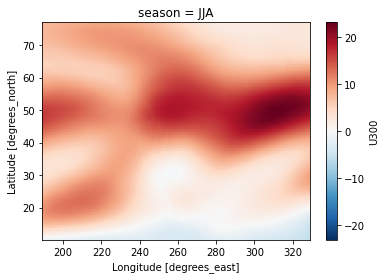

In [13]:
# what do negative values mean? direction?
# I think positive = westerlies (west to east), negative = easterlies (east to west)
U300_hist_smean.sel(season='JJA').plot()

In [14]:
U300_hist_smean.min().values

array(-5.6925883, dtype=float32)

In [15]:
U300_hist_smean.max().values

array(47.952812, dtype=float32)

In [16]:
U300_rcp_smean.min().values

array(-5.4900036, dtype=float32)

In [17]:
U300_rcp_smean.max().values

array(36.028286, dtype=float32)

### Calculate seasonal difference

In [19]:
U300_diff_smean = U300_rcp_smean - U300_hist_smean
U300_diff_smean = U300_diff_smean.persist()

In [20]:
U300_diff_smean.min().values

array(-11.924526, dtype=float32)

In [21]:
U300_diff_smean.max().values

array(6.3175583, dtype=float32)

### Panel plot with seasonal means and differences

why is this so slow?? I think because dask resources weren't deployed during open_mfdataset calls, because time bounds fix doesn't work when dask resources are deployed

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/scratch/kdagon/ipykernel_99835/676924366.py:40: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
/glade/scratch/kdagon/ipykernel_99835/676924366.py:62: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter w

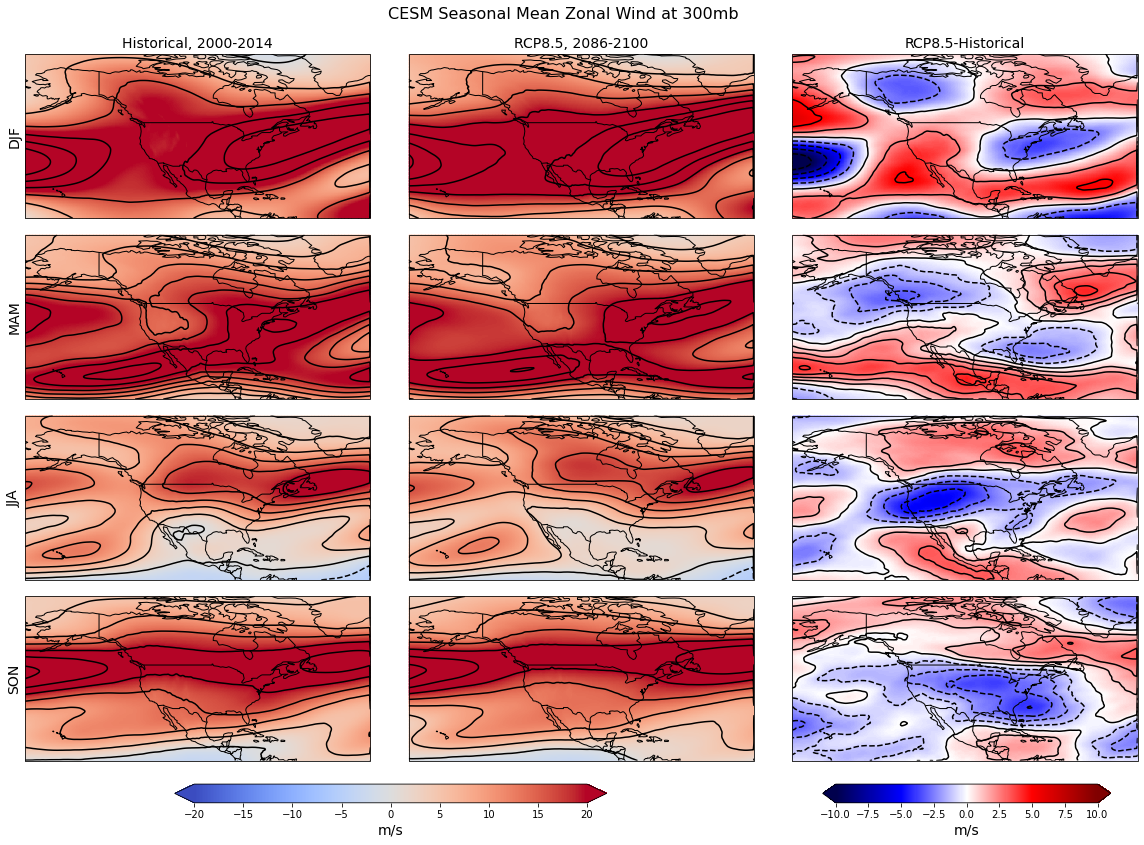

In [21]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=-20
vmax=20
# discrete colormap
#cmap=plt.cm.get_cmap('Greens', 8)
#vmax=4 # for absolute plots

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(U300_hist_smean.sel(season=season), coord=U300_hist_smean.lon)
    lat = U300_hist_smean.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(U300_rcp_smean.sel(season=season), coord=U300_rcp_smean.lon)
    lat = U300_rcp_smean.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('m/s', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-10
vmax2=10

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
    field, lon = add_cyclic_point(U300_diff_smean.sel(season=season), coord=U300_diff_smean.lon)
    lat = U300_diff_smean.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('m/s', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Zonal Wind at 300mb', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_U300_smean.png', bbox_inches='tight')

## Read in surface temperature

In [29]:
# h4.TS is 3hrly instantaneous surface temperature (hist, RCP2.6)
# h5.TS is 3hrly instantaneous surface tempreature (RCP8.5)
# remapped from unstructured grid to FV

TS_files = "*TS*.nc"

### Preprocessing function

In [30]:
def preprocess_TS(ds):
    # return TS data array
    return ds['TS']

### Read in files with preprocessing function

In [31]:
%%time
TS_hist = xr.open_mfdataset(cesm_hist_filepath+TS_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess_TS)
TS_hist

CPU times: user 193 ms, sys: 14 ms, total: 207 ms
Wall time: 2.14 s


<xarray.DataArray 'TS' (time: 17520, lat: 68, lon: 141)>
dask.array<concatenate, shape=(17520, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

drop the final time index from hist (repeats)

In [32]:
TS_hist = TS_hist[:-1,:,:]
TS_hist

<xarray.DataArray 'TS' (time: 17519, lat: 68, lon: 141)>
dask.array<getitem, shape=(17519, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2005-12-31 21:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

In [33]:
TS_rcp26 = xr.open_mfdataset(cesm_rcp26_filepath+TS_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess_TS)
TS_rcp26

<xarray.DataArray 'TS' (time: 29200, lat: 68, lon: 141)>
dask.array<concatenate, shape=(29200, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

### Combine historical/rcp2.6

In [34]:
TS_present = xr.concat([TS_hist, TS_rcp26], dim='time')
TS_present

<xarray.DataArray 'TS' (time: 46719, lat: 68, lon: 141)>
dask.array<concatenate, shape=(46719, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

### Subset historical to match number of RCP8.5 years (14)

In [35]:
TS_present = TS_present[:43800] 
TS_present

<xarray.DataArray 'TS' (time: 43800, lat: 68, lon: 141)>
dask.array<getitem, shape=(43800, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

In [36]:
TS_rcp85 = xr.open_mfdataset(cesm_rcp85_filepath+TS_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess_TS)
TS_rcp85

<xarray.DataArray 'TS' (time: 43800, lat: 68, lon: 141)>
dask.array<concatenate, shape=(43800, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

### Calculate seasonal means and persist for plotting

In [37]:
TS_present_smean = TS_present.groupby("time.season").mean(dim='time').persist()
TS_rcp85_smean = TS_rcp85.groupby("time.season").mean(dim='time').persist()

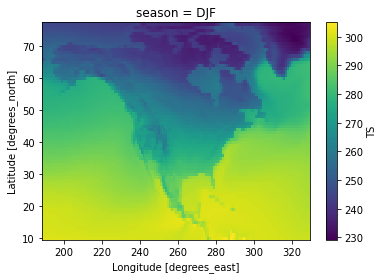

In [38]:
# test plot
TS_present_smean.sel(season='DJF').plot()

In [39]:
KtoC = -273.15
TS_present_smean.min().values + KtoC # convert to degC

-43.99884643554685

In [40]:
TS_present_smean.max().values + KtoC

39.68520507812502

In [41]:
TS_rcp85_smean.min().values + KtoC

-40.78739013671873

In [42]:
TS_rcp85_smean.max().values + KtoC

44.61403808593752

### Calculate seasonal difference

In [43]:
TS_diff_smean = TS_rcp85_smean - TS_present_smean
TS_diff_smean = TS_diff_smean.persist()

In [44]:
TS_diff_smean.min().values

array(-4.405609, dtype=float32)

In [45]:
TS_diff_smean.max().values

array(28.308395, dtype=float32)

### Panel plot with seasonal means and differences

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-pac

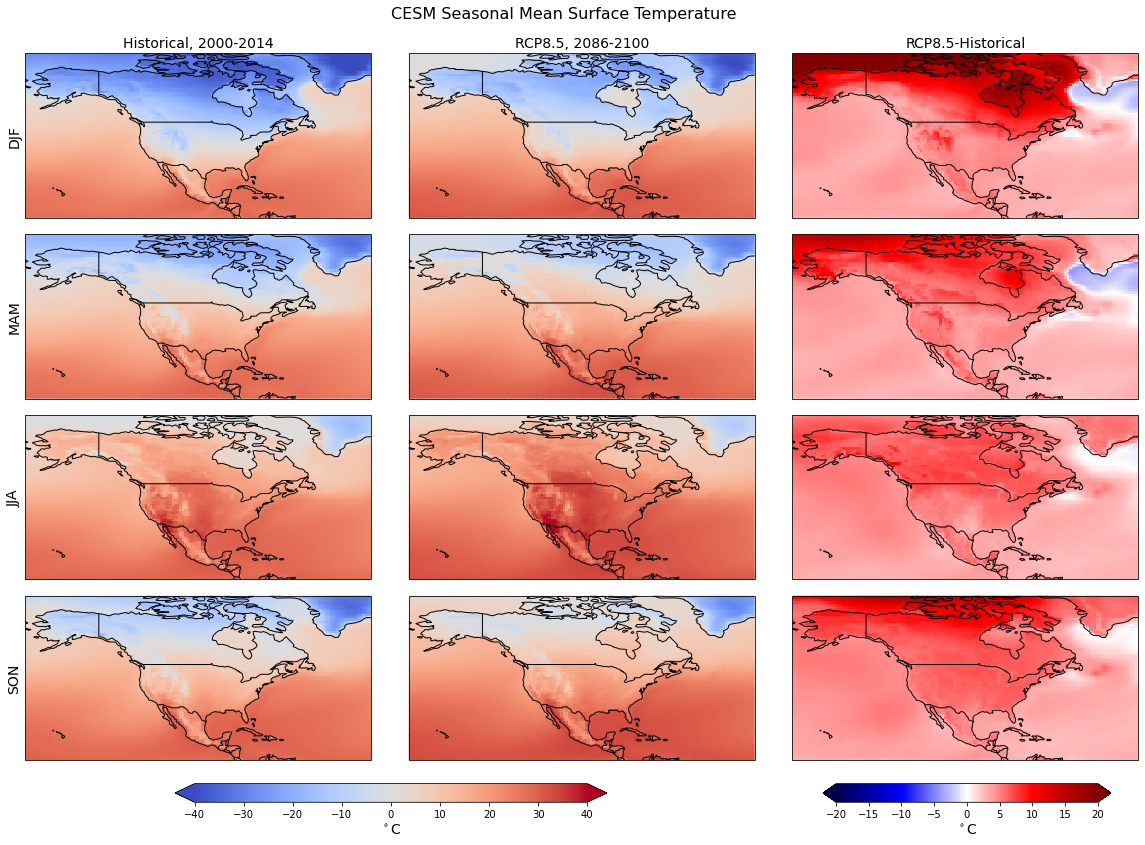

In [46]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=-40
vmax=40

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(TS_present_smean.sel(season=season)+KtoC, coord=TS_present_smean.lon)
    lat = TS_present_smean.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(TS_rcp85_smean.sel(season=season)+KtoC, coord=TS_rcp85_smean.lon)
    lat = TS_rcp85_smean.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('$^\circ$C', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-20
vmax2=20

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
    field, lon = add_cyclic_point(TS_diff_smean.sel(season=season), coord=TS_diff_smean.lon)
    lat = TS_diff_smean.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('$^\circ$C', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Surface Temperature', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_TS_smean.png', bbox_inches='tight')

### Plot CONUS only

In [47]:
TS_present_smean.sel(lat=slice(26,50), lon=slice(235,292)).min().values + KtoC

-17.055273437499977

In [48]:
TS_present_smean.sel(lat=slice(26,50), lon=slice(235,292)).max().values + KtoC

39.68520507812502

In [49]:
TS_rcp85_smean.sel(lat=slice(26,50), lon=slice(235,292)).min().values + KtoC

-8.837988281249977

In [50]:
TS_rcp85_smean.sel(lat=slice(26,50), lon=slice(235,292)).max().values + KtoC

44.61403808593752

In [51]:
TS_diff_smean.sel(lat=slice(26,50), lon=slice(235,292)).min().values

array(1.2319641, dtype=float32)

In [52]:
TS_diff_smean.sel(lat=slice(26,50), lon=slice(235,292)).max().values

array(9.522614, dtype=float32)

/glade/scratch/kdagon/ipykernel_94875/272705768.py:37: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
/glade/scratch/kdagon/ipykernel_94875/272705768.py:59: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')


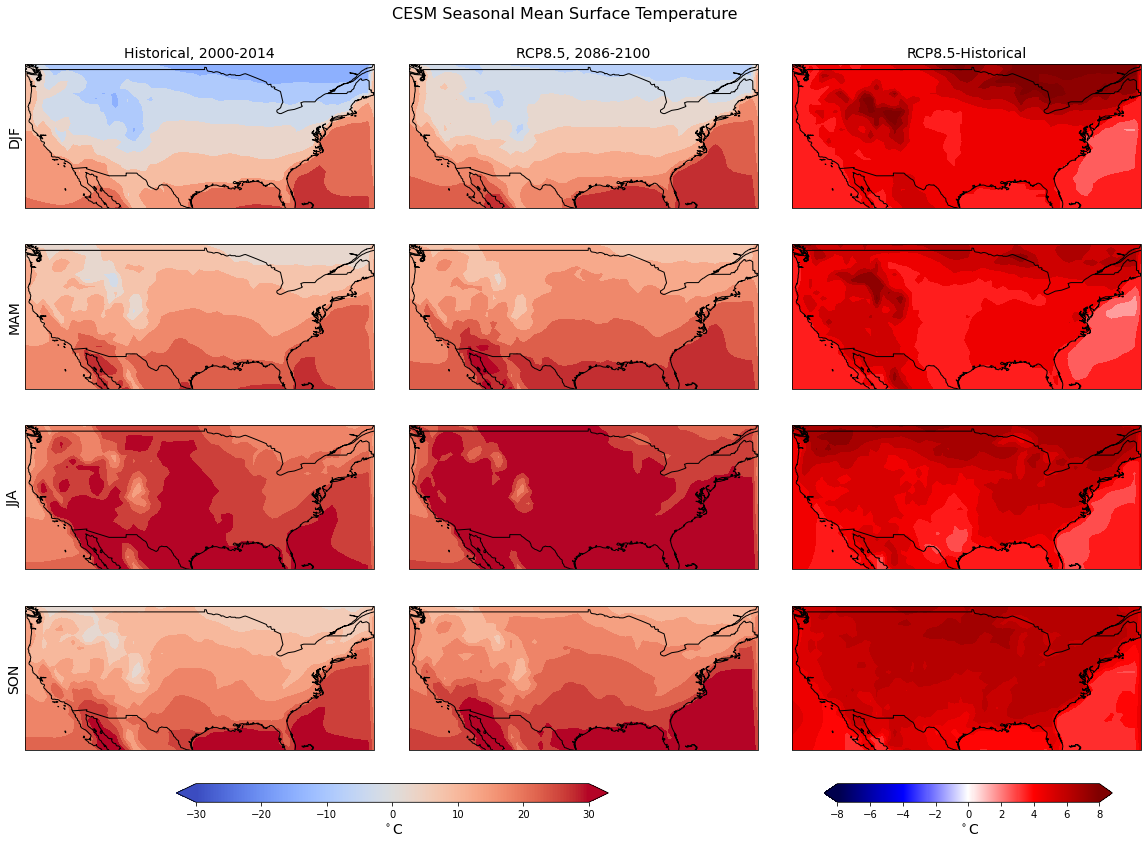

In [53]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=-30
vmax=30

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(TS_present_smean.sel(season=season, lat=slice(26,50), lon=slice(235,292))+KtoC, coord=TS_present_smean.sel(lat=slice(26,50), lon=slice(235,292)).lon)
    lat = TS_present_smean.sel(lat=slice(26,50), lon=slice(235,292)).lat
    #cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(TS_rcp85_smean.sel(season=season, lat=slice(26,50), lon=slice(235,292))+KtoC, coord=TS_rcp85_smean.sel(lat=slice(26,50), lon=slice(235,292)).lon)
    lat = TS_rcp85_smean.sel(lat=slice(26,50), lon=slice(235,292)).lat
    #cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('$^\circ$C', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-8
vmax2=8

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
    field, lon = add_cyclic_point(TS_diff_smean.sel(season=season, lat=slice(26,50), lon=slice(235,292)), coord=TS_diff_smean.sel(lat=slice(26,50), lon=slice(235,292)).lon)
    lat = TS_diff_smean.sel(lat=slice(26,50), lon=slice(235,292)).lat
    #cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('$^\circ$C', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Surface Temperature', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_TS_smean_CONUS_contour.png', bbox_inches='tight')

## Read in sea level pressure

In [5]:
# h4.PSL is 3hrly instantaneous sea level pressure (hist, RCP2.6)
# h5.PSL is 3hrly instantaneous sea level pressure (RCP8.5)
# remapped from unstructured grid to FV

PSL_files = "*PSL*.nc"

### Preprocessing function

In [6]:
def preprocess_PSL(ds):
    # return PSL data array
    return ds['PSL']

### Read in files with preprocessing function

In [7]:
%%time
PSL_hist = xr.open_mfdataset(cesm_hist_filepath+PSL_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess_PSL)
PSL_hist

CPU times: user 452 ms, sys: 21.2 ms, total: 473 ms
Wall time: 5.74 s


<xarray.DataArray 'PSL' (time: 17520, lat: 68, lon: 141)>
dask.array<concatenate, shape=(17520, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_measures:  area: area

drop the final time index from hist (repeats)

In [8]:
PSL_hist = PSL_hist[:-1,:,:]
PSL_hist

<xarray.DataArray 'PSL' (time: 17519, lat: 68, lon: 141)>
dask.array<getitem, shape=(17519, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2005-12-31 21:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_measures:  area: area

In [9]:
PSL_rcp26 = xr.open_mfdataset(cesm_rcp26_filepath+PSL_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess_PSL)
PSL_rcp26

<xarray.DataArray 'PSL' (time: 29200, lat: 68, lon: 141)>
dask.array<concatenate, shape=(29200, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_measures:  area: area

### Combine historical/rcp2.6

In [10]:
PSL_present = xr.concat([PSL_hist, PSL_rcp26], dim='time')
PSL_present

<xarray.DataArray 'PSL' (time: 46719, lat: 68, lon: 141)>
dask.array<concatenate, shape=(46719, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_measures:  area: area

### Subset historical to match number of RCP8.5 years (14)

In [11]:
PSL_present = PSL_present[:43800] 
PSL_present

<xarray.DataArray 'PSL' (time: 43800, lat: 68, lon: 141)>
dask.array<getitem, shape=(43800, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_measures:  area: area

In [29]:
PSL_rcp85 = xr.open_mfdataset(cesm_rcp85_filepath+PSL_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess_PSL)
PSL_rcp85

<xarray.DataArray 'PSL' (time: 43800, lat: 68, lon: 141)>
dask.array<concatenate, shape=(43800, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_measures:  area: area

### Calculate seasonal means and (optionally) persist for plotting

In [30]:
PSL_present_smean = PSL_present.groupby("time.season").mean(dim='time') #.persist()
PSL_rcp85_smean = PSL_rcp85.groupby("time.season").mean(dim='time') #.persist()

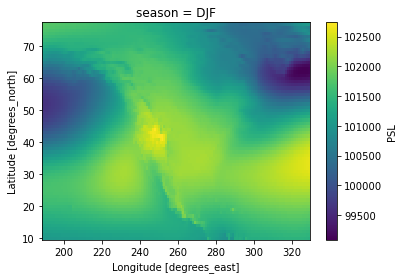

In [63]:
# test plot - units are Pa
PSL_present_smean.sel(season='DJF').plot()

In [64]:
PSL_present_smean.min().values*.01 # convert Pa to hPa

990.86390625

In [65]:
PSL_present_smean.max().values*.01

1028.694296875

In [66]:
PSL_rcp85_smean.min().values*.01

994.0217968750001

In [67]:
PSL_rcp85_smean.max().values*.01

1027.100546875

### Calculate seasonal difference

In [31]:
PSL_diff_smean = PSL_rcp85_smean - PSL_present_smean
PSL_diff_smean = PSL_diff_smean.persist()

In [32]:
PSL_diff_smean.min().values*.01

-9.5890625

In [33]:
PSL_diff_smean.max().values*.01

5.963046875

### Panel plot with seasonal means and differences

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-pac

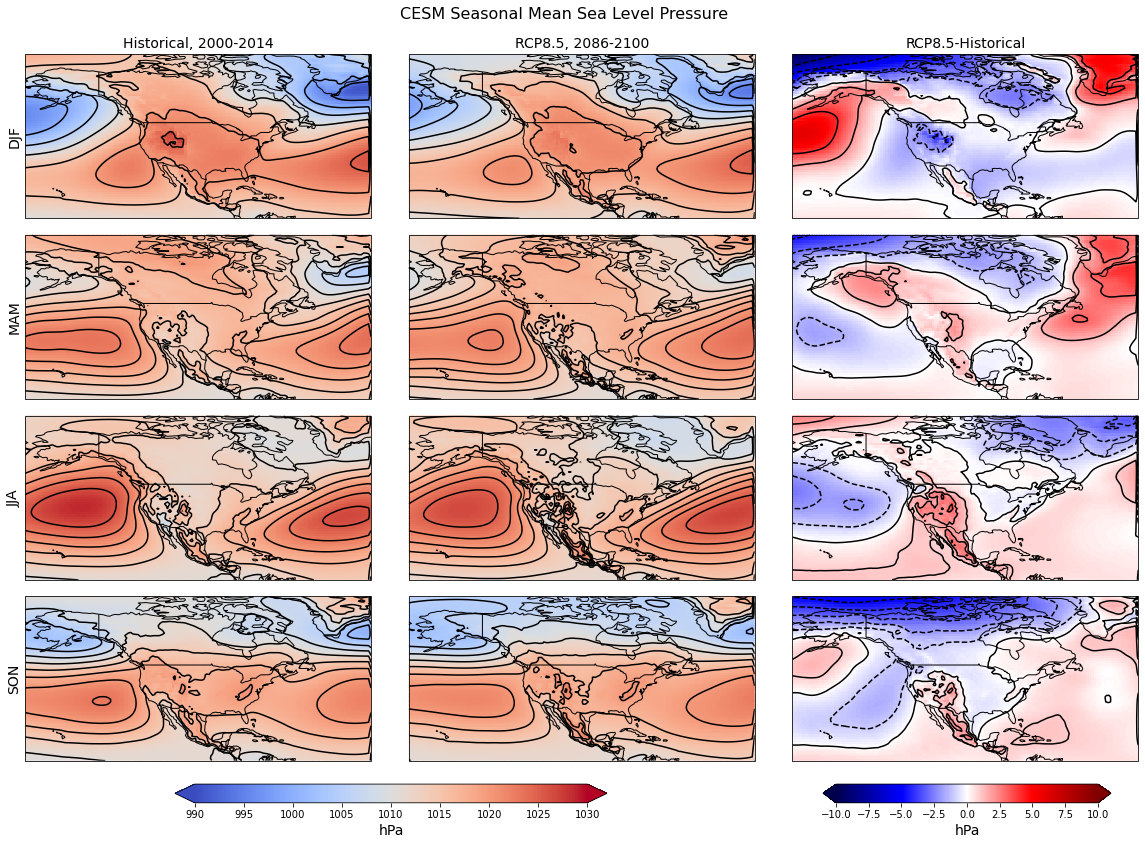

In [71]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=990
vmax=1030

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(PSL_present_smean.sel(season=season)*0.01, coord=PSL_present_smean.lon)
    lat = PSL_present_smean.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(PSL_rcp85_smean.sel(season=season)*0.01, coord=PSL_rcp85_smean.lon)
    lat = PSL_rcp85_smean.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('hPa', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-10
vmax2=10

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
    field, lon = add_cyclic_point(PSL_diff_smean.sel(season=season)*0.01, coord=PSL_diff_smean.lon)
    lat = PSL_diff_smean.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('hPa', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Sea Level Pressure', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_PSL_smean.png', bbox_inches='tight')

## Compare PSL across CESM/MERRA

Redo the CESM present concat to get the full 2000-2015 CESM climatology

In [12]:
PSL_present_full = xr.concat([PSL_hist, PSL_rcp26], dim='time')
PSL_present_full

<xarray.DataArray 'PSL' (time: 46719, lat: 68, lon: 141)>
dask.array<concatenate, shape=(46719, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_measures:  area: area

### Read in MERRA SLP

In [13]:
merra_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/MERRA-2/"

In [14]:
# MERRA uses "SLP" for sea level pressure
SLP_files = "*SLP*.nc"

In [15]:
def preprocess_SLP(ds):
    # return SLP data array
    return ds['SLP']

In [16]:
# note MERRA number of timesteps are not the same because of leap years! and the 3hrly index sampling is not exactly the same as CESM
#%%time
SLP_merra = xr.open_mfdataset(merra_filepath+SLP_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess_SLP)
SLP_merra

<xarray.DataArray 'SLP' (time: 46752, lat: 68, lon: 141)>
dask.array<concatenate, shape=(46752, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) datetime64[ns] 2000-01-01T01:30:00 ... 2015-12-31T22:30:00
Attributes:
    standard_name:   sea_level_pressure
    long_name:       sea_level_pressure
    units:           Pa
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    origname:        SLP
    fullnamepath:    /SLP

### Calculate seasonal means and persist for plotting

In [17]:
SLP_merra_smean = SLP_merra.groupby("time.season").mean(dim='time').persist()

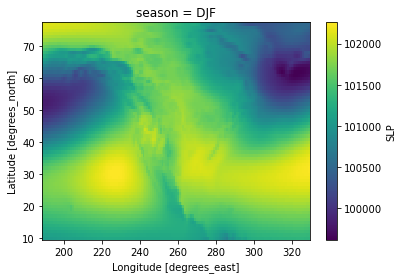

In [81]:
# test plot - units are Pa
SLP_merra_smean.sel(season='DJF').plot()

In [82]:
SLP_merra_smean.min().values*.01 # convert Pa to hPa

996.1509375

In [83]:
SLP_merra_smean.max().values*.01

1025.08046875

In [18]:
PSL_present_full_smean = PSL_present_full.groupby("time.season").mean(dim='time').persist()

In [85]:
PSL_present_full_smean.min().values*.01

990.934921875

In [86]:
PSL_present_full_smean.max().values*.01

1028.66453125

### Calculate seasonal difference, CESM-MERRA

In [19]:
SLP_diff_smean = PSL_present_full_smean - SLP_merra_smean
SLP_diff_smean = SLP_diff_smean.persist()

In [88]:
SLP_diff_smean.min().values*.01

-5.796484375

In [89]:
SLP_diff_smean.max().values*.01

10.721796875

### Panel plot with seasonal means and differences

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-pac

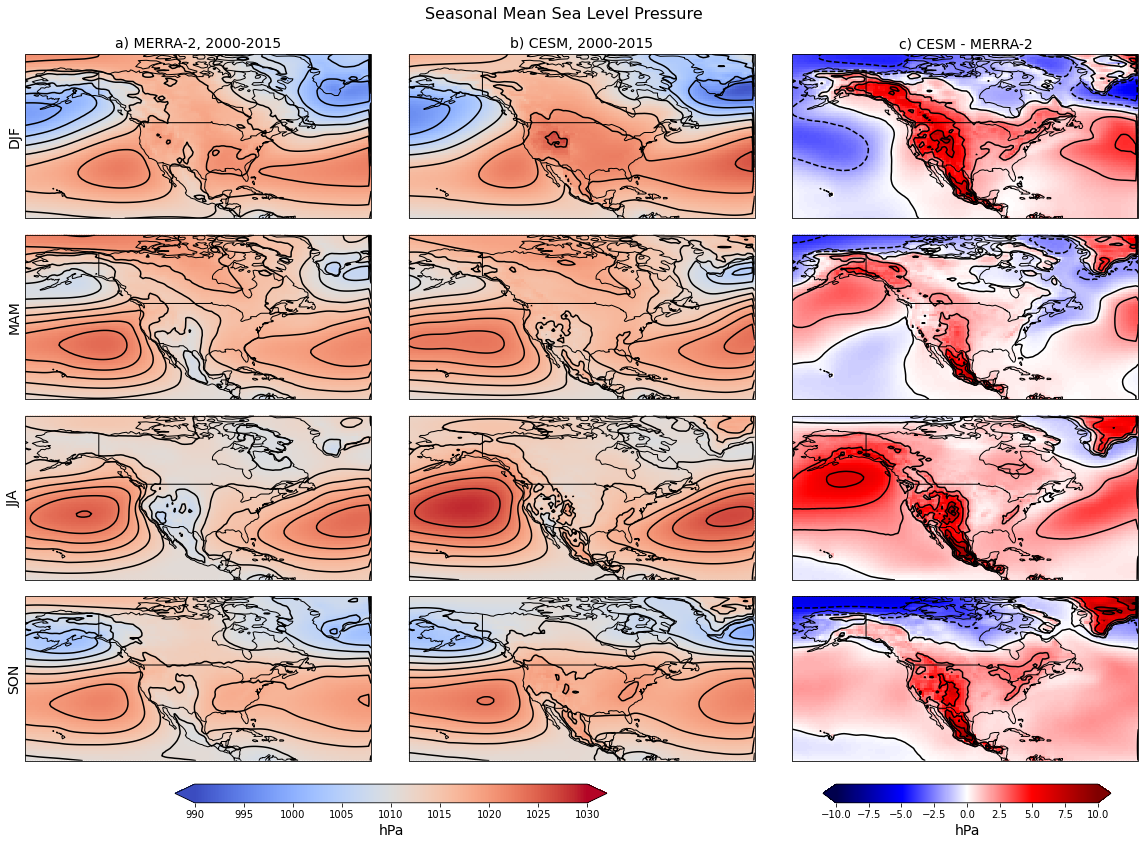

In [21]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=990
vmax=1030

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('a) MERRA-2, 2000-2015', fontsize=14) 
    field, lon = add_cyclic_point(SLP_merra_smean.sel(season=season)*0.01, coord=SLP_merra_smean.lon)
    lat = SLP_merra_smean.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('b) CESM, 2000-2015', fontsize=14)
    field, lon = add_cyclic_point(PSL_present_full_smean.sel(season=season)*0.01, coord=PSL_present_full_smean.lon)
    lat = PSL_present_full_smean.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('hPa', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-10
vmax2=10

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('c) CESM - MERRA-2', fontsize=14)
    field, lon = add_cyclic_point(SLP_diff_smean.sel(season=season)*0.01, coord=SLP_diff_smean.lon)
    lat = SLP_diff_smean.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('hPa', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Seasonal Mean Sea Level Pressure', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/merra_cesm_diff_SLP_smean.png', bbox_inches='tight')

## Read in geopotential height

In [34]:
# h0.Z300 is monthly mean 300mb geopotential height
# remapped from unstructured grid to FV

Z300_B20TRC5CN_file = "b.e13.B20TRC5CN.ne120_g16.003.cam.h0.Z300.200001-200512.regrid_0.23x0.31.nc"
Z300_BRCP26C5CN_file = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h0.Z300.200601-201512.regrid_0.23x0.31.nc"
Z300_BRCP85C5CN_file = "b.e13.BRCP85C5CN.ne120_g16.003.cam.h0.Z300.208601-210012.regrid_0.23x0.31.nc"

In [35]:
Z300_hist_files = [cesm_hist_filepath+Z300_B20TRC5CN_file, cesm_rcp26_filepath+Z300_BRCP26C5CN_file] # combined hist/rcp26; need explicit filenames (not glob strings) if using a list
Z300_rcp_file = cesm_rcp85_filepath+Z300_BRCP85C5CN_file

In [36]:
Z300_hist_files

['/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/b.e13.B20TRC5CN.ne120_g16.003.cam.h0.Z300.200001-200512.regrid_0.23x0.31.nc',
 '/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP26C5CN/b.e13.BRCP26C5CN.ne120_g16.003.cam.h0.Z300.200601-201512.regrid_0.23x0.31.nc']

### Preprocessing function for geopotential height
Note: this doesn't work with dask for reasons I don't understand, alternatively do this manually after reading in dataset

In [19]:
def preprocess_Z300(ds):
    # fix CESM time bounds for monthly output
    attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
    # limitation with dask here seems to be ds.cf - not finding cf attribute when dask client is enabled, but does work without dask
    time_bounds = ds.cf.get_bounds('time') #.load() # need to load time_bounds because .mean won't operate on a dask array
    time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
    ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
    ds.time.attrs, ds.time.encoding = attrs, encoding
    # return regional domain
    #return ds['Z300'].sel(lat=slice(10,77),lon=slice(189,329))
    # return global domain
    return ds['Z300']

### Read in Z300 files
With or without preprocessing function

In [37]:
%%time
#Z300_hist = xr.open_mfdataset(Z300_hist_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess_Z300) # unclear if chunking is needed for these monthly (smaller) files
Z300_hist_ds = xr.open_mfdataset(Z300_hist_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True)

CPU times: user 76.6 ms, sys: 3.8 ms, total: 80.4 ms
Wall time: 862 ms


In [38]:
Z300_hist_ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 768, lon: 1152, nbnd: 2, slat: 767, slon: 1152, time: 192)
Coordinates:
  * lat        (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon        (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * slat       (slat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
  * slon       (slon) float64 0.0 0.1562 0.4688 0.7812 ... 358.9 359.2 359.5
  * time       (time) object 2000-02-01 00:00:00 ... 2016-01-01 00:00:00
Dimensions without coordinates: bnds, nbnd
Data variables:
    w_stag     (time, slat) float64 dask.array<chunksize=(72, 767), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(72, 768, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(72, 1152, 2), meta=np.ndarray>
    gw         (time, lat) float64 dask.array<chunksize=(72, 768), meta=np.ndarray>
    area       (time, lat, lon) float64 dask.array<chunksize=(72, 768, 1152), meta=np.ndarray>
    Z300       (time, lat, lon) float32 dask.array<chunksize=(72, 768, 1152), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(72, 2), meta=np.ndarray>
Attributes: (12/30)
    creation_date:              Mon Mar 21 19:18:40 MDT 2022
    Conventions:                CF-1.0
    source_file:                /glade/scratch/kdagon/FrontDetector/B20TRC5CN...
    data_script:                ncl script using vinth2p_nodes
    cesm_contact:               John Truesdale, jet@ucar.edu
    data_creator:               Katie Dagon, kdagon@ucar.edu
    ...                         ...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc38
    remap_version:              4.7.9
    map_file:                   /glade/work/nanr/mapfiles/map_ne120_to_0.23x0...
    input_file:                 /glade/scratch/kdagon/FrontDetector/B20TRC5CN...

In [39]:
attrs, encoding = Z300_hist_ds.time.attrs.copy(), Z300_hist_ds.time.encoding.copy()
time_bounds = Z300_hist_ds.cf.get_bounds('time').load()
time_bounds_dim_name = Z300_hist_ds.cf.get_bounds_dim_name('time')
Z300_hist_ds = Z300_hist_ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
Z300_hist_ds.time.attrs, Z300_hist_ds.time.encoding = attrs, encoding
Z300_hist = Z300_hist_ds['Z300']
Z300_hist

<xarray.DataArray 'Z300' (time: 192, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(192, 768, 1152), dtype=float32, chunksize=(120, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-16 12:00:00 ... 2015-12-16 12:00:00
Attributes:
    long_name:      Geopotential height at 300 mbar pressure surface
    unita:          m
    plevo:          300.0
    cell_measures:  area: area

### Subset historical to match number of RCP8.5 years (14)

In [40]:
Z300_hist = Z300_hist[:180] 
Z300_hist

<xarray.DataArray 'Z300' (time: 180, lat: 768, lon: 1152)>
dask.array<getitem, shape=(180, 768, 1152), dtype=float32, chunksize=(108, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      Geopotential height at 300 mbar pressure surface
    unita:          m
    plevo:          300.0
    cell_measures:  area: area

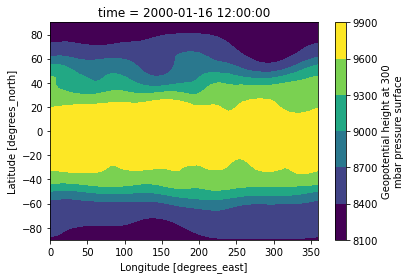

In [79]:
Z300_hist.isel(time=0).plot.contourf()

In [41]:
Z300_rcp_ds = xr.open_dataset(Z300_rcp_file, chunks={'time':150})
# because it's only one file, have to use open_dataset and do the preprocessing manually
attrs, encoding = Z300_rcp_ds.time.attrs.copy(), Z300_rcp_ds.time.encoding.copy()
time_bounds = Z300_rcp_ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
time_bounds_dim_name = Z300_rcp_ds.cf.get_bounds_dim_name('time')
Z300_rcp_ds = Z300_rcp_ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
Z300_rcp_ds.time.attrs, Z300_rcp_ds.time.encoding = attrs, encoding
# regional domain
#Z300_rcp = Z300_rcp_ds['Z300'].sel(lat=slice(10,77),lon=slice(189,329))
# global domain
Z300_rcp = Z300_rcp_ds['Z300']
Z300_rcp

<xarray.DataArray 'Z300' (time: 180, lat: 768, lon: 1152)>
dask.array<open_dataset-33a60087542267c83c072a6a36a47cf0Z300, shape=(180, 768, 1152), dtype=float32, chunksize=(150, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2086-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:      Geopotential height at 300 mbar pressure surface
    unita:          m
    plevo:          300.0
    cell_measures:  area: area

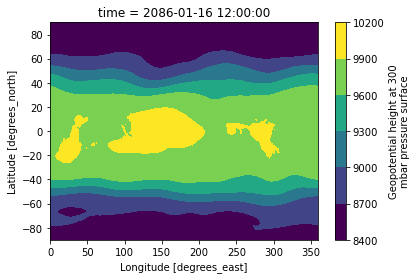

In [81]:
Z300_rcp.isel(time=0).plot.contourf()

### Weighted global mean function
From ADF: https://github.com/NCAR/ADF/blob/main/scripts/analysis/amwg_table.py

In [42]:
def spatial_average(indata):
    import xarray as xr
    import numpy as np
    assert 'lev' not in indata.coords
    assert 'ilev' not in indata.coords
    if 'lat' in indata.coords:
        weights = np.cos(np.deg2rad(indata.lat))
        weights.name = "weights"
    elif 'ncol' in indata.coords:
        print("WARNING: We need a way to get area variable. Using equal weights.")
        weights = xr.DataArray(1.)
        weights.name = "weights"
    else:
        weights = xr.DataArray(1.)
        weights.name = "weights"
    weighted = indata.weighted(weights)
    # we want to average over all non-time dimensions
    avgdims = [dim for dim in indata.dims if dim != 'time']
    return weighted.mean(dim=avgdims)

### Calculate the global mean with time for each simulation period

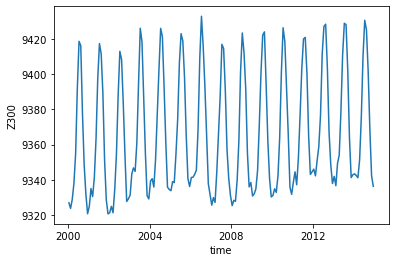

In [43]:
Z300_hist_gm = spatial_average(Z300_hist)
Z300_hist_gm.plot()

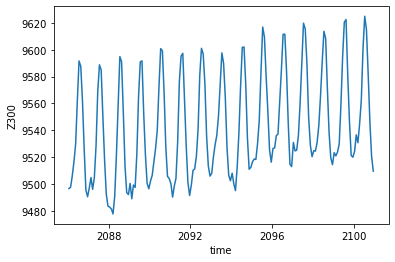

In [44]:
Z300_rcp_gm = spatial_average(Z300_rcp)
Z300_rcp_gm.plot()

In [45]:
# seasonal mean
Z300_hist_gm_smean = Z300_hist_gm.groupby("time.season").mean(dim='time')
Z300_hist_gm_smean

<xarray.DataArray 'Z300' (season: 4)>
dask.array<stack, shape=(4,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [46]:
Z300_rcp_gm_smean = Z300_rcp_gm.groupby("time.season").mean(dim='time')
Z300_rcp_gm_smean

<xarray.DataArray 'Z300' (season: 4)>
dask.array<stack, shape=(4,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [47]:
# seasonal mean differences
Z300_gm_smean_diff = Z300_rcp_gm_smean - Z300_hist_gm_smean
Z300_gm_smean_diff.values

array([174.11463943, 180.33970095, 175.94476699, 174.562882  ])

In [164]:
# how do the regional mean values compare?
Z300_hist_rm_smean = spatial_average(Z300_hist.sel(lat=slice(10,77),lon=slice(189,329))).groupby("time.season").mean(dim='time')
Z300_rcp_rm_smean = spatial_average(Z300_rcp.sel(lat=slice(10,77),lon=slice(189,329))).groupby("time.season").mean(dim='time')
Z300_rm_smean_diff = Z300_rcp_rm_smean - Z300_hist_rm_smean
Z300_rm_smean_diff.values
# DJF and MAM (3rd index!) are very similar, but JJA and SON have larger regional mean changes so the plots do change in terms of the lesser features

array([172.8198182 , 192.75843348, 174.87311902, 189.67510728])

### Calculate seasonal means over space and (optionally) persist for plotting
Subset North American domain if not already done

In [48]:
#Z300_hist_smean = Z300_hist.groupby("time.season").mean(dim='time').persist()
#Z300_rcp_smean = Z300_rcp.groupby("time.season").mean(dim='time').persist()
Z300_hist_smean = Z300_hist.sel(lat=slice(10,77),lon=slice(189,329)).groupby("time.season").mean(dim='time') #.persist()
Z300_rcp_smean = Z300_rcp.sel(lat=slice(10,77),lon=slice(189,329)).groupby("time.season").mean(dim='time') #.persist()

In [167]:
Z300_hist_smean

<xarray.DataArray 'Z300' (season: 4, lat: 285, lon: 448)>
dask.array<stack, shape=(4, 285, 448), dtype=float32, chunksize=(1, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

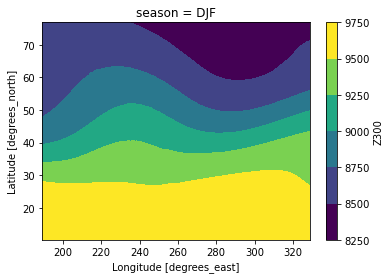

In [90]:
# test plot - units are m
Z300_hist_smean.sel(season='DJF').plot.contourf()

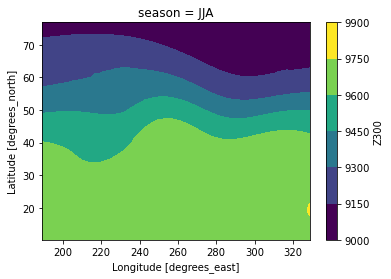

In [91]:
Z300_hist_smean.sel(season='JJA').plot.contourf()

In [92]:
Z300_hist_smean.min().values

array(8382.898, dtype=float32)

In [93]:
Z300_hist_smean.max().values

array(9751.211, dtype=float32)

In [94]:
Z300_rcp_smean.min().values

array(8522.228, dtype=float32)

In [95]:
Z300_rcp_smean.max().values

array(9944.708, dtype=float32)

### Calculate seasonal difference

In [49]:
Z300_diff_smean = Z300_rcp_smean - Z300_hist_smean
#Z300_diff_smean = Z300_diff_smean.persist()
Z300_diff_smean

<xarray.DataArray 'Z300' (season: 4, lat: 285, lon: 448)>
dask.array<sub, shape=(4, 285, 448), dtype=float32, chunksize=(1, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

### Subtract the global mean seasonal mean differences from each gridpoint
Persist for plotting

In [50]:
Z300_diff_smean_minusgm = Z300_diff_smean - Z300_gm_smean_diff
Z300_diff_smean_minusgm = Z300_diff_smean_minusgm.persist()

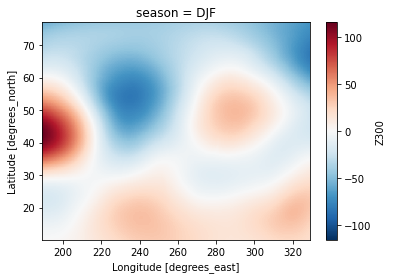

In [173]:
Z300_diff_smean_minusgm.sel(season='DJF').plot()

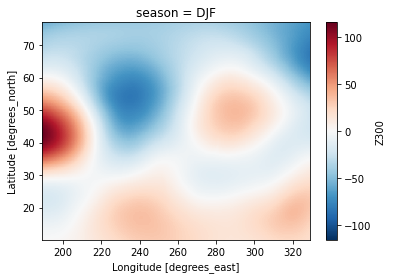

In [176]:
# sanity check
(Z300_diff_smean.sel(season='DJF') - 174.11463943).plot()

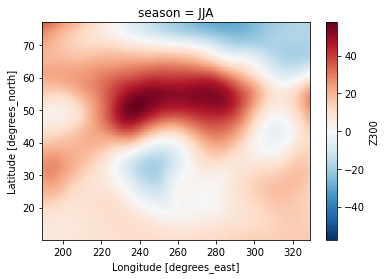

In [183]:
Z300_diff_smean_minusgm.sel(season='JJA').plot()

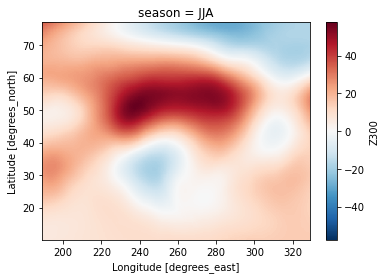

In [184]:
(Z300_diff_smean.sel(season='JJA') - 180.33970095).plot()

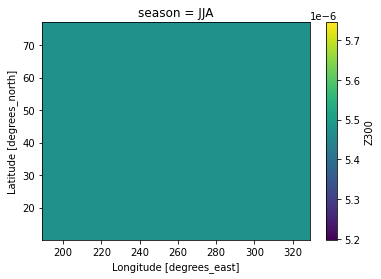

In [185]:
(Z300_diff_smean_minusgm.sel(season='JJA') - (Z300_diff_smean.sel(season='JJA') - 180.33970095)).plot()

In [51]:
#Z300_diff_smean.min().values
Z300_diff_smean_minusgm.min().values

array(-90.72797011)

In [52]:
#Z300_diff_smean.max().values
Z300_diff_smean_minusgm.max().values

array(115.47618088)

### Test subtracting the regional mean differences

In [169]:
Z300_diff_smean_minusrm = Z300_diff_smean - Z300_rm_smean_diff
Z300_diff_smean_minusrm = Z300_diff_smean_minusrm.persist()

### Panel plot with seasonal means and differences

/glade/scratch/kdagon/ipykernel_176391/2159383003.py:41: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
/glade/scratch/kdagon/ipykernel_176391/2159383003.py:75: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')


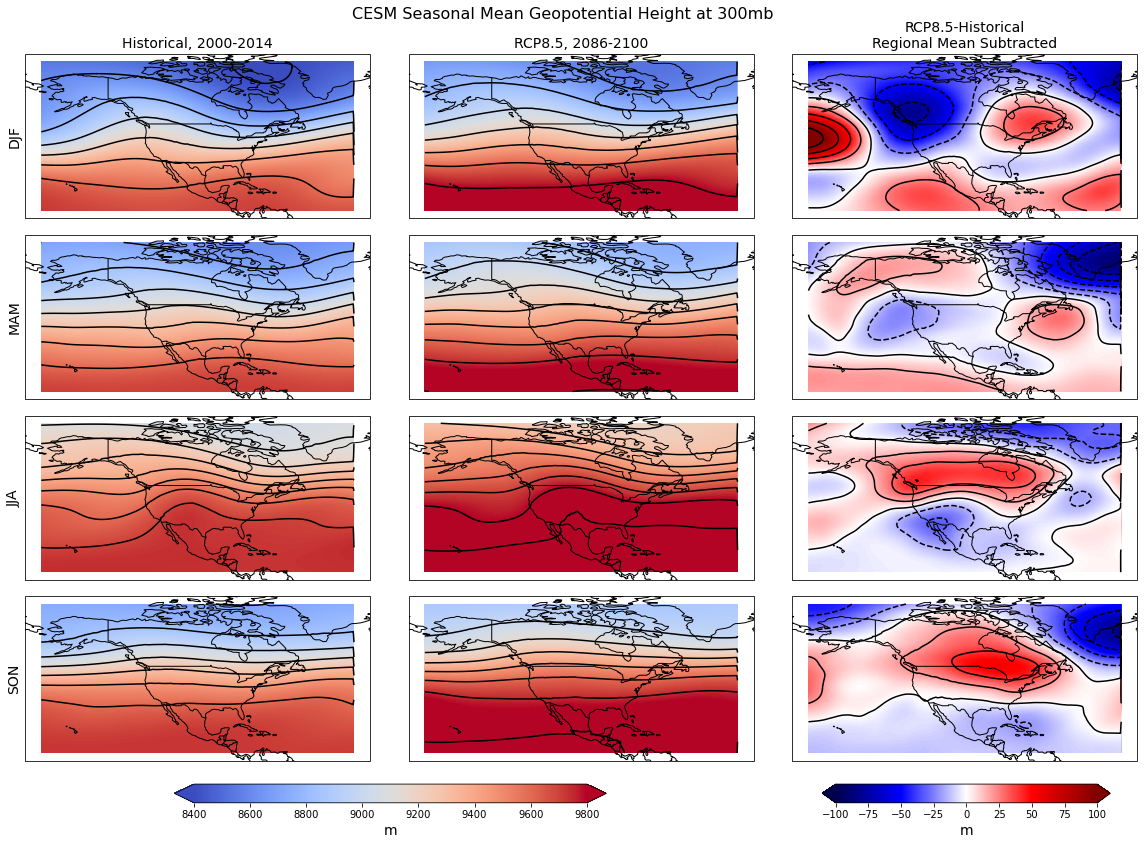

In [170]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

#cmap = plt.cm.get_cmap('coolwarm', 14)
cmap = plt.cm.get_cmap('coolwarm')
vmin=8400
vmax=9800

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(Z300_hist_smean.sel(season=season), coord=Z300_hist_smean.lon)
    lat = Z300_hist_smean.lat
    axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black') # this needs to be first otherwise spatial domain gets cut off
    #cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()) # pcolor takes longer
    cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()) # leaves a white outline
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #print(seastrings[i])
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(Z300_rcp_smean.sel(season=season), coord=Z300_rcp_smean.lon)
    lat = Z300_rcp_smean.lat
    axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    #cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('m', fontsize=14)

# difference plot
#cmap2 = plt.cm.get_cmap('seismic', 12)
cmap2 = plt.cm.get_cmap('seismic')
# absolute differences
#vmin2=-300
#vmax2=300
# "normalized" differences
vmin2=-100
vmax2=100

for i, season in enumerate(seastrings):
    if i==0:
        #axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
        #axs[i,2].set_title('RCP8.5-Historical\nGlobal Mean Subtracted', fontsize=14)
        axs[i,2].set_title('RCP8.5-Historical\nRegional Mean Subtracted', fontsize=14)
    #field, lon = add_cyclic_point(Z300_diff_smean.sel(season=season), coord=Z300_diff_smean.lon)
    #lat = Z300_diff_smean.lat
    #field, lon = add_cyclic_point(Z300_diff_smean_minusgm.sel(season=season), coord=Z300_diff_smean_minusgm.lon)
    #lat = Z300_diff_smean_minusgm.lat
    field, lon = add_cyclic_point(Z300_diff_smean_minusrm.sel(season=season), coord=Z300_diff_smean_minusrm.lon)
    lat = Z300_diff_smean_minusrm.lat
    axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    #cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    cf = axs[i,2].pcolormesh(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('m', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Geopotential Height at 300mb', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_Z300_smean.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_Z300_smean_discrete.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_Z300_smean_minusgm.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_Z300_smean_minusrm.png', bbox_inches='tight')

### Read in Z500 files

In [109]:
# h0.Z300 is monthly mean 300mb geopotential height
# remapped from unstructured grid to FV

Z500_B20TRC5CN_file = "b.e13.B20TRC5CN.ne120_g16.003.cam.h0.Z500.200001-200512.regrid_0.23x0.31.nc"
Z500_BRCP26C5CN_file = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h0.Z500.200601-201512.regrid_0.23x0.31.nc"
Z500_BRCP85C5CN_file = "b.e13.BRCP85C5CN.ne120_g16.003.cam.h0.Z500.208601-210012.regrid_0.23x0.31.nc"

Z500_hist_files = [cesm_hist_filepath+Z500_B20TRC5CN_file, cesm_rcp26_filepath+Z500_BRCP26C5CN_file] # combined hist/rcp26; need explicit filenames (not glob strings) if using a list
Z500_rcp_file = cesm_rcp85_filepath+Z500_BRCP85C5CN_file

In [135]:
Z500_hist_ds = xr.open_mfdataset(Z500_hist_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True)
Z500_hist_ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 768, lon: 1152, nbnd: 2, slat: 767, slon: 1152, time: 192)
Coordinates:
  * lat        (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon        (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * slat       (slat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
  * slon       (slon) float64 0.0 0.1562 0.4688 0.7812 ... 358.9 359.2 359.5
  * time       (time) object 2000-02-01 00:00:00 ... 2016-01-01 00:00:00
Dimensions without coordinates: bnds, nbnd
Data variables:
    w_stag     (time, slat) float64 dask.array<chunksize=(72, 767), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(72, 768, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(72, 1152, 2), meta=np.ndarray>
    gw         (time, lat) float64 dask.array<chunksize=(72, 768), meta=np.ndarray>
    area       (time, lat, lon) float64 dask.array<chunksize=(72, 768, 1152), meta=np.ndarray>
    Z500       (time, lat, lon) float32 dask.array<chunksize=(72, 768, 1152), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(72, 2), meta=np.ndarray>
Attributes: (12/30)
    creation_date:              Mon Mar 21 19:18:40 MDT 2022
    Conventions:                CF-1.0
    source_file:                /glade/scratch/kdagon/FrontDetector/B20TRC5CN...
    data_script:                ncl script using vinth2p_nodes
    cesm_contact:               John Truesdale, jet@ucar.edu
    data_creator:               Katie Dagon, kdagon@ucar.edu
    ...                         ...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             casper-login2
    remap_version:              4.7.9
    map_file:                   /glade/work/nanr/mapfiles/map_ne120_to_0.23x0...
    input_file:                 /glade/scratch/kdagon/FrontDetector/B20TRC5CN...

In [136]:
attrs, encoding = Z500_hist_ds.time.attrs.copy(), Z500_hist_ds.time.encoding.copy()
time_bounds = Z500_hist_ds.cf.get_bounds('time').load()
time_bounds_dim_name = Z500_hist_ds.cf.get_bounds_dim_name('time')
Z500_hist_ds = Z500_hist_ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
Z500_hist_ds.time.attrs, Z500_hist_ds.time.encoding = attrs, encoding
Z500_hist = Z500_hist_ds['Z500']
Z500_hist

<xarray.DataArray 'Z500' (time: 192, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(192, 768, 1152), dtype=float32, chunksize=(120, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-16 12:00:00 ... 2015-12-16 12:00:00
Attributes:
    long_name:      Geopotential height at 500 mbar pressure surface
    unita:          m
    plevo:          500.0
    cell_measures:  area: area

In [137]:
Z500_hist = Z500_hist[:180] 
Z500_hist

<xarray.DataArray 'Z500' (time: 180, lat: 768, lon: 1152)>
dask.array<getitem, shape=(180, 768, 1152), dtype=float32, chunksize=(108, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      Geopotential height at 500 mbar pressure surface
    unita:          m
    plevo:          500.0
    cell_measures:  area: area

In [138]:
Z500_rcp_ds = xr.open_dataset(Z500_rcp_file, chunks={'time':150})
attrs, encoding = Z500_rcp_ds.time.attrs.copy(), Z500_rcp_ds.time.encoding.copy()
time_bounds = Z500_rcp_ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
time_bounds_dim_name = Z500_rcp_ds.cf.get_bounds_dim_name('time')
Z500_rcp_ds = Z500_rcp_ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
Z500_rcp_ds.time.attrs, Z500_rcp_ds.time.encoding = attrs, encoding
# regional domain
#Z500_rcp = Z500_rcp_ds['Z500'].sel(lat=slice(10,77),lon=slice(189,329))
# global domain
Z500_rcp = Z500_rcp_ds['Z500']
Z500_rcp

<xarray.DataArray 'Z500' (time: 180, lat: 768, lon: 1152)>
dask.array<open_dataset-10ec99836101054e872248eb5c18926dZ500, shape=(180, 768, 1152), dtype=float32, chunksize=(150, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2086-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:      Geopotential height at 500 mbar pressure surface
    unita:          m
    plevo:          500.0
    cell_measures:  area: area

In [139]:
Z500_hist_gm_smean = spatial_average(Z500_hist).groupby("time.season").mean(dim='time')
Z500_rcp_gm_smean = spatial_average(Z500_rcp).groupby("time.season").mean(dim='time')
Z500_rcp_gm_smean

<xarray.DataArray 'Z500' (season: 4)>
dask.array<stack, shape=(4,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [140]:
Z500_gm_smean_diff = Z500_rcp_gm_smean - Z500_hist_gm_smean
Z500_gm_smean_diff.values

array([95.79735471, 99.77024944, 96.63574918, 96.53947222])

In [141]:
Z500_hist_smean = Z500_hist.sel(lat=slice(10,77),lon=slice(189,329)).groupby("time.season").mean(dim='time').persist()
Z500_rcp_smean = Z500_rcp.sel(lat=slice(10,77),lon=slice(189,329)).groupby("time.season").mean(dim='time').persist()

In [142]:
Z500_hist_smean.min().values

array(5042.8984, dtype=float32)

In [143]:
Z500_hist_smean.max().values

array(5949.4355, dtype=float32)

In [144]:
Z500_rcp_smean.min().values

array(5137.6797, dtype=float32)

In [145]:
Z500_rcp_smean.max().values

array(6055.5137, dtype=float32)

In [146]:
Z500_diff_smean = Z500_rcp_smean - Z500_hist_smean

### Subtract the global mean seasonal mean differences from each gridpoint
Persist for plotting

In [147]:
Z500_diff_smean_minusgm = Z500_diff_smean - Z500_gm_smean_diff
Z500_diff_smean_minusgm = Z500_diff_smean_minusgm.persist()

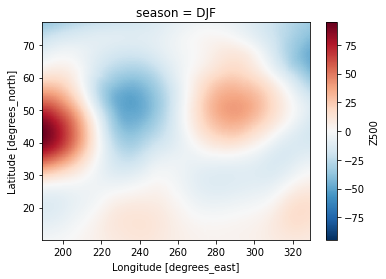

In [150]:
Z500_diff_smean_minusgm.sel(season='DJF').plot()

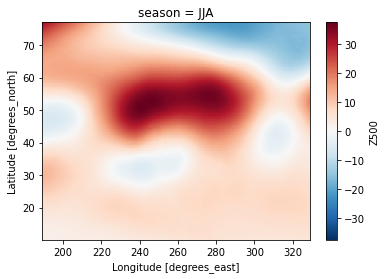

In [151]:
Z500_diff_smean_minusgm.sel(season='JJA').plot()

In [152]:
Z500_diff_smean_minusgm.min().values

array(-57.14551481)

In [153]:
Z500_diff_smean_minusgm.max().values

array(94.58985232)

### Panel plot with seasonal means and differences

<timed exec>:38: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
<timed exec>:62: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


CPU times: user 9min 50s, sys: 3.28 s, total: 9min 54s
Wall time: 10min 12s


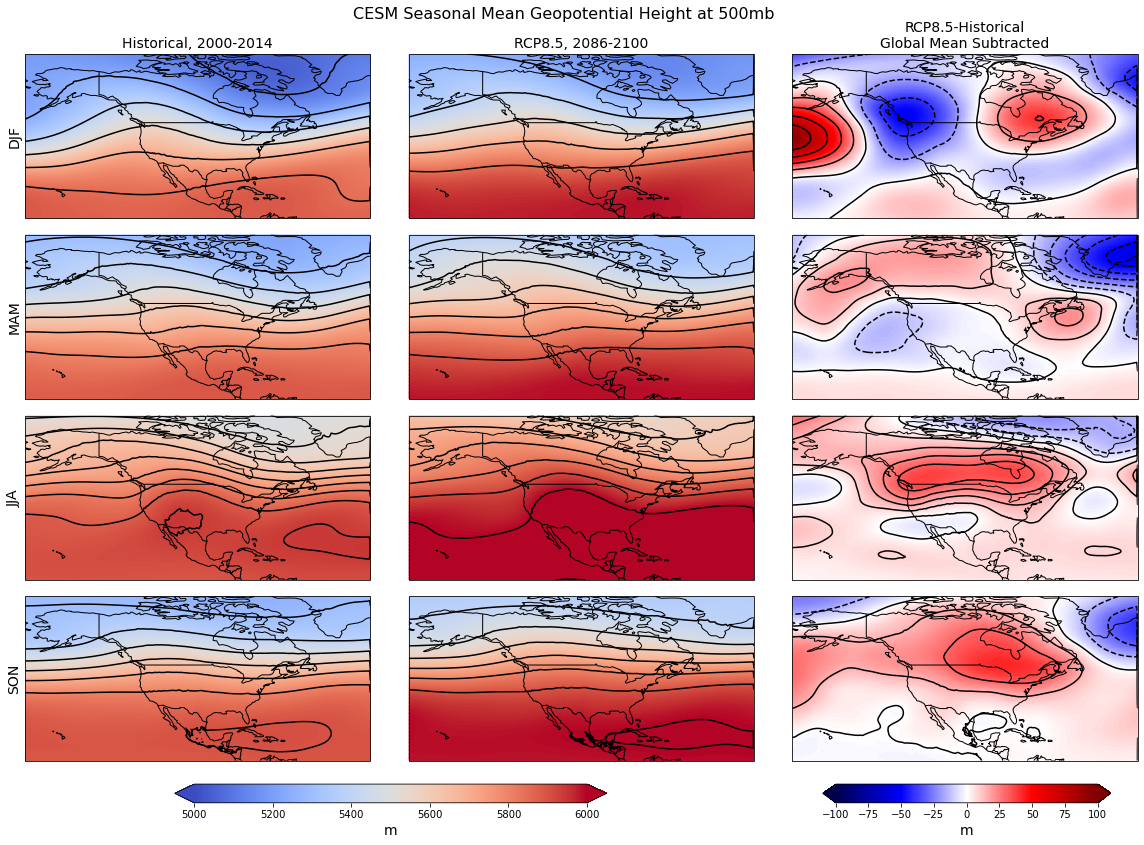

In [162]:
%%time
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=5000
vmax=6000

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(Z500_hist_smean.sel(season=season), coord=Z500_hist_smean.lon)
    lat = Z500_hist_smean.lat
    axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black') # this needs to be first otherwise spatial domain gets cut off
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()) # pcolor takes much longer, pcolormesh is fast but leaves a white outline around plot
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #print(seastrings[i])
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(Z500_rcp_smean.sel(season=season), coord=Z500_rcp_smean.lon)
    lat = Z500_rcp_smean.lat
    axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('m', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
# "normalized" differences
vmin2=-100
vmax2=100

for i, season in enumerate(seastrings):
    if i==0:
        #axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
        axs[i,2].set_title('RCP8.5-Historical\nGlobal Mean Subtracted', fontsize=14)
    field, lon = add_cyclic_point(Z500_diff_smean_minusgm.sel(season=season), coord=Z500_diff_smean_minusgm.lon)
    lat = Z500_diff_smean_minusgm.lat
    axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('m', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Geopotential Height at 500mb', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_Z500_smean_minusgm_pcolormesh.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_Z500_smean_minusgm.png', bbox_inches='tight')

### Panel the differences only: U300, Z300, SLP

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/scratch/kdagon/ipykernel_122757/259455124.py:27: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm1, orientation='horizontal', extend='both')
/glade/scratch/kdagon/ipykernel_122757/259455124.py:48: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the paramete

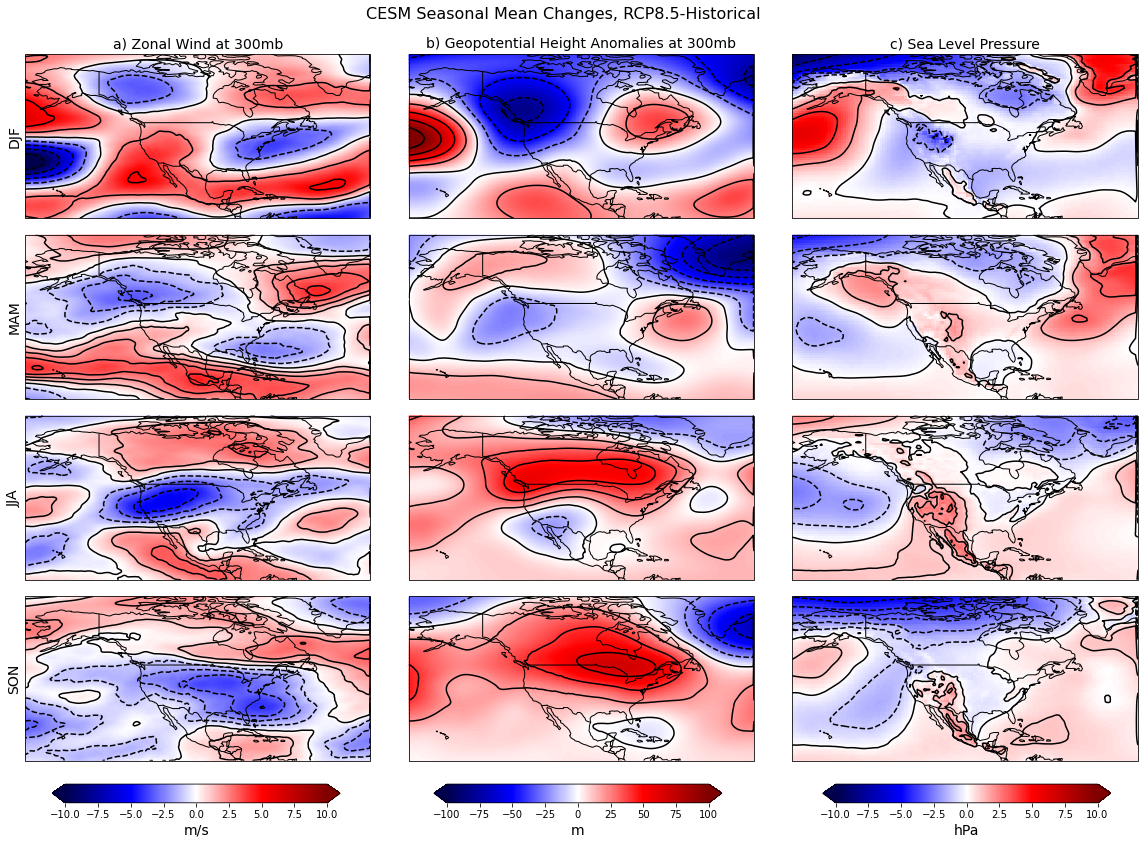

In [55]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('seismic')

# U300 difference plot
vmin1=-10
vmax1=10

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,0].set_title('a) Zonal Wind at 300mb', fontsize=14)
    field, lon = add_cyclic_point(U300_diff_smean.sel(season=season), coord=U300_diff_smean.lon)
    lat = U300_diff_smean.lat
    axs[i,0].contour(lon, lat, field, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree(), colors='black')
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

# U300 colorbar
cb1_ax = fig.add_axes([0.145, 0.08, 0.2, 0.02])
norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm1, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('m/s', fontsize=14)

# Z300 difference plot
# "normalized" differences
vmin2=-100
vmax2=100

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,1].set_title('b) Geopotential Height Anomalies at 300mb', fontsize=14)
    field, lon = add_cyclic_point(Z300_diff_smean_minusgm.sel(season=season), coord=Z300_diff_smean_minusgm.lon)
    lat = Z300_diff_smean_minusgm.lat
    axs[i,1].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)

# Z300 colorbar
cb2_ax = fig.add_axes([0.41, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('m', fontsize=14)

# PSL difference plot
vmin3=-10
vmax3=10

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('c) Sea Level Pressure', fontsize=14)
    field, lon = add_cyclic_point(PSL_diff_smean.sel(season=season)*0.01, coord=PSL_diff_smean.lon)
    lat = PSL_diff_smean.lat
    axs[i,2].contour(lon, lat, field, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree(), colors='black')
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# PSL colorbar
cb3_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap, norm=norm3, orientation='horizontal', extend='both')
cb3.ax.set_xlabel('hPa', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Changes, RCP8.5-Historical', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_U300_Z300_PSL_smean.png', bbox_inches='tight')

In [56]:
client.close()
cluster.close()